# Imports

In [31]:
# Data preprocessing
import numpy as np
import pandas as pd
import os
import shutil
import random
import time
import pickle
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torch import optim

from torchvision import transforms,models
from torchinfo import summary

# Visualizing
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math

# Import model weights

In [71]:
epochs = glob('/kaggle/input/model-checkpoint/*')
epochs = sorted(epochs, key=lambda x: int(x.split('_')[-1]))

In [33]:
input_base = '/kaggle/input/model-checkpoint'
output_base = '/kaggle/working'

for epoch in tqdm(epochs, desc='Copying Folders'):
    epoch_x = epoch.split('/')[-1]
    destination = os.path.join(output_base, epoch_x)

    if os.path.exists(destination):
        #print(f"Skipping {epoch_x} — already exists.")
        continue

    source = os.path.join(input_base, epoch_x)
    shutil.copytree(source, destination, dirs_exist_ok=True)

Copying Folders:   0%|          | 0/21 [00:00<?, ?it/s]

In [34]:
workers = 2
isCuda = True
device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True
print("Device: {}".format(device))

model_saved_dir = "/kaggle/working"

Device: cuda:0


# Model Initializations

In [35]:
seed = 42
random.seed(seed)
torch.manual_seed(seed)

In [36]:
# StarGAN v2 Hyperparameters

nf = 64             # Base number of filters in Generator/Discriminator
nd = 10             # Number of domains (camera classes)
sdim = 64           # Dimension of style code (output of Style Encoder)

# Loss weights
lambda_gp  = 1.     # Gradient penalty for discriminator
lambda_sty = 1.     # Style consistency loss
lambda_ds  = 1.      # Diversity sensitive loss
lambda_cyc = 1.     # Cycle consistency loss

# Optimizer settings
lr = 1e-4           # Learning rate for G, D, E
betas = (0.0, 0.99) # Adam optimizer betas
weight_decay = 1e-4 # Weight decay for regularization

# Training loop settings
batch_size   = 4    # Batch size
epochs       = 30   # Total number of training epochs
ds_epochs    = 5    # Epochs after which diversity-sensitive loss is annealed to 0
n_print      = 100  # Print loss after every n iterations
n_img_save   = 2000 # Generate images after every n iterations


In [37]:
# Weight initializations
def init_conv_weight(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.)

def init_fc_weight_zero(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.)

def init_fc_weight_one(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)

# Dataset & DataLoader

In [38]:
img_path = glob('/kaggle/input/ieee-sp-cup-camera-model-identification-dataset/*/*')
print(f"Image Loaded: {len(img_path)}")

Image Loaded: 55000


In [39]:
df = pd.DataFrame(img_path,columns=['image_path'])
df['camera_model'] = df['image_path'].apply(lambda x: x.split('/')[-2])

In [40]:
df

,image_path,camera_model
0,/kaggle/input/ieee-sp-cup-camera-model-identif...,Samsung-Galaxy-S4
1,/kaggle/input/ieee-sp-cup-camera-model-identif...,Samsung-Galaxy-S4
2,/kaggle/input/ieee-sp-cup-camera-model-identif...,Samsung-Galaxy-S4
3,/kaggle/input/ieee-sp-cup-camera-model-identif...,Samsung-Galaxy-S4
4,/kaggle/input/ieee-sp-cup-camera-model-identif...,Samsung-Galaxy-S4
...,...,...
54995,/kaggle/input/ieee-sp-cup-camera-model-identif...,LG-Nexus-5x
54996,/kaggle/input/ieee-sp-cup-camera-model-identif...,LG-Nexus-5x
54997,/kaggle/input/ieee-sp-cup-camera-model-identif...,LG-Nexus-5x
54998,/kaggle/input/ieee-sp-cup-camera-model-identif...,LG-Nexus-5x


In [41]:
le = LabelEncoder()
df['camera_model'] = le.fit_transform(df['camera_model'])
df['camera_model'].value_counts()

camera_model
6    5500
8    5500
9    5500
5    5500
0    5500
2    5500
7    5500
3    5500
4    5500
1    5500
Name: count, dtype: int64

In [42]:
le.inverse_transform([1,2])

array(['LG-Nexus-5x', 'Motorola-Droid-Maxx'], dtype=object)

In [43]:
train_df, test_df = train_test_split(
    df,
    test_size=0.1,              # 10% for test (or validation)
    stratify=df['camera_model'],       # keep camera balance
    random_state=42
)

In [44]:
train_df['camera_model'].value_counts()

camera_model
5    4950
1    4950
7    4950
9    4950
4    4950
8    4950
6    4950
3    4950
0    4950
2    4950
Name: count, dtype: int64

In [45]:
test_df['camera_model'].value_counts()

camera_model
1    550
9    550
8    550
2    550
5    550
7    550
3    550
0    550
6    550
4    550
Name: count, dtype: int64

In [46]:
class CameraPatchDataset(Dataset):
    def __init__(self, img_paths, labels, transform='test'):
        self.image_paths = img_paths.tolist()
        self.labels = labels.tolist()
        if transform == 'train':
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),  # geometric only
                transforms.ToTensor(),
                transforms.Normalize((0.5,)*3,(0.5,)*3)  # keep for stable training
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,)*3,(0.5,)*3)  # keep for stable training
            ])
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


In [47]:
# Load dataset
train_dataset = CameraPatchDataset(train_df['image_path'], train_df['camera_model'], transform='train')
test_dataset = CameraPatchDataset(test_df['image_path'], test_df['camera_model'], transform='test')

# Main training loaders
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
ref_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
#ref2_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Evaluation/test loaders
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
ref_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [48]:
def unnormalize(tensor):
    # Assumes Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    return tensor * 0.5 + 0.5

In [49]:
# # Assume image_path is a list or Series of valid paths
# # Pick first 100 (or randomly sample 100)
# fig, axes = plt.subplots(10, 10, figsize=(15, 15))
# plt.subplots_adjust(wspace=0.1, hspace=0.1)

# for i, ax in enumerate(axes.flat):
#     ax.imshow(unnormalize(test_dataset[i][0]).permute(1,2,0))
#     ax.axis('off')

# plt.show()

# Model

In [50]:
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=False, down=False):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, in_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)

        self.norm = norm
        if norm:
            self.norm1 = nn.InstanceNorm2d(in_ch, affine=True)
            self.norm2 = nn.InstanceNorm2d(in_ch, affine=True)

        self.lrelu = nn.LeakyReLU(0.2)
        self.is_down = down

        self.is_sc = in_ch != out_ch
        if self.is_sc:
            self.sc = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)

    def down(self, x):
        return F.avg_pool2d(x, 2)

    def forward(self, x):
        if self.norm: res = self.norm1(x)
        else: res = x
        res = self.conv1(self.lrelu(res))
        if self.is_sc: x = self.sc(x)
        if self.is_down:
            x = self.down(x)
            res = self.down(res)
        if self.norm: res = self.norm2(res)
        res = self.conv2(self.lrelu(res))
        return (x + res) / math.sqrt(2)

In [51]:
class AdaIN(nn.Module):
    def __init__(self, sdim, nf):
        super(AdaIN, self).__init__()
        self.norm = nn.InstanceNorm2d(nf)
        self.gamma = nn.Linear(sdim, nf)
        self.beta = nn.Linear(sdim, nf)
        self.apply(init_fc_weight_one)

    def forward(self, x, s):
        B, C, H, W = x.size()
        return (1 + self.gamma(s).view(B, C, 1, 1)) * self.norm(x) + self.beta(s).view(B, C, 1, 1)

In [52]:
class AdaINResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, sdim, up=False):
        super(AdaINResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1)
        self.norm1 = AdaIN(sdim, in_ch)
        self.norm2 = AdaIN(sdim, out_ch)
        self.lrelu = nn.LeakyReLU(0.2)
        self.is_up = up
        self.is_sc = in_ch != out_ch
        if self.is_sc:
            self.sc = nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False)

    def up(self, x):
        return F.interpolate(x, scale_factor=2, mode='nearest')

    def forward(self, x, s):
        res = self.lrelu(self.norm1(x, s))
        if self.is_up:
            x = self.up(x)
            res = self.up(res)
        if self.is_sc: x = self.sc(x)
        res = self.conv1(res)
        res = self.conv2(self.lrelu(self.norm2(res, s)))
        return (x + res) / math.sqrt(2)

In [53]:
class Generator(nn.Module):
    def __init__(self, nf, sdim):
        super(Generator, self).__init__()
        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        self.enc = nn.Sequential(
            ResBlock(nf, 2*nf, norm=True, down=True),
            ResBlock(2*nf, 4*nf, norm=True, down=True),
            ResBlock(4*nf, 8*nf, norm=True, down=True),
            ResBlock(8*nf, 8*nf, norm=True),
            ResBlock(8*nf, 8*nf, norm=True)
        )
        self.dec = nn.ModuleList([
            AdaINResBlock(8*nf, 8*nf, sdim),
            AdaINResBlock(8*nf, 8*nf, sdim),
            AdaINResBlock(8*nf, 4*nf, sdim, up=True),
            AdaINResBlock(4*nf, 2*nf, sdim, up=True),
            AdaINResBlock(2*nf, nf, sdim, up=True)
        ])
        self.conv_out = nn.Sequential(
            nn.InstanceNorm2d(nf, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(nf, 3, 1, 1, 0)
        )
        self.apply(init_conv_weight)

    def forward(self, x, s):
        x = self.conv_in(x)
        x = self.enc(x)
        for layer in self.dec:
            x = layer(x, s)
        x = self.conv_out(x)
        return x

In [54]:
class StyleEncoder(nn.Module):
    def __init__(self, nf, nd, sdim):
        super().__init__()
        self.nd = nd
        self.sdim = sdim

        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        # 5 downsamples → H/32 × W/32
        self.res = nn.Sequential(
            ResBlock(nf,  2*nf, down=True),
            ResBlock(2*nf, 4*nf, down=True),
            ResBlock(4*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True),
        )
        # Pool to 1×1 then map to nd*sdim
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv_out = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, nd*sdim, 1, 1, 0)
        )
        self.apply(init_conv_weight)

    def forward(self, x, y):
        B = x.size(0)
        x = self.conv_in(x)        # → [B, nf, H, W]
        x = self.res(x)            # → [B, 8*nf, H/32, W/32]
        x = self.pool(x)           # → [B, 8*nf, 1, 1]
        out = self.conv_out(x)     # → [B, nd*sdim, 1, 1]
        style = out.view(B, self.nd, self.sdim)  # → [B, nd, sdim]

        # ensure y is a LongTensor on the same device
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.long, device=style.device)
        else:
            y = y.to(style.device)

        # pick each sample’s style vector
        return style[torch.arange(B, device=style.device), y]  # → [B, sdim]


In [55]:
class Discriminator(nn.Module):
    def __init__(self, nf, nd):
        super(Discriminator, self).__init__()
        self.conv_in = nn.Conv2d(3, nf, 3, 1, 1)
        self.res = nn.Sequential(
            ResBlock(nf, 2*nf, down=True),
            ResBlock(2*nf, 4*nf, down=True),
            ResBlock(4*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True),
            ResBlock(8*nf, 8*nf, down=True)
        )
        self.conv_out = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, 8*nf, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8*nf, nd, 1, 1, 0)
        )
        self.apply(init_conv_weight)

    def forward(self, x, y):  # x: B x 3 x H x W, y: B
        B = x.size(0)
        x = self.conv_in(x)         # B x nf x H x W
        x = self.res(x)             # B x 8nf x 4 x 4
        x = self.conv_out(x)        # B x nd x 1 x 1
        x = x.view(B, -1)           # B x nd
    
        if not torch.is_tensor(y):
            y = torch.tensor(y, dtype=torch.long, device=x.device)
        elif y.device != x.device:
            y = y.to(x.device)
    
        i = torch.arange(B, device=x.device)
        return x[i, y]              # B


In [56]:
class Model:
    def __init__(self, nf, nd, sdim, lr, betas, weight_decay):
        self.G = Generator(nf, sdim).cuda()
        #self.F = MappingNetwork(nz, nd, sdim).cuda()
        self.D = Discriminator(nf, nd).cuda()
        self.E = StyleEncoder(nf, nd, sdim).cuda()

        self.optG = optim.Adam(self.G.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        #self.optF = optim.Adam(self.F.parameters(), lr=lr_f, betas=betas, weight_decay=weight_decay)
        self.optD = optim.Adam(self.D.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optE = optim.Adam(self.E.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

    def save(self, path):
        torch.save(self.G.state_dict(), path + '_G.pt')
        #torch.save(self.F.state_dict(), path + '_F.pt')
        torch.save(self.D.state_dict(), path + '_D.pt')
        torch.save(self.E.state_dict(), path + '_E.pt')

    def load(self, path):
        self.G.load_state_dict(torch.load(path + '_G.pt'))
        #self.F.load_state_dict(torch.load(path + '_F.pt'))
        self.D.load_state_dict(torch.load(path + '_D.pt'))
        self.E.load_state_dict(torch.load(path + '_E.pt'))

    def zero_grad(self):
        self.optG.zero_grad()
        #self.optF.zero_grad()
        self.optD.zero_grad()
        self.optE.zero_grad()

    def train(self):
        self.G.train()
        #self.F.train()
        self.D.train()
        self.E.train()

    def eval(self):
        self.G.eval()
        #self.F.eval()
        self.D.eval()
        self.E.eval()

In [57]:
model = Model(nf, nd, sdim, lr, betas, weight_decay)

In [58]:
def gradient_penalty(out, x):
    grad = torch.autograd.grad(
        outputs=out.sum(),
        inputs=x,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0].view(x.size(0), -1)
    return 0.5 * torch.mean(torch.sum(grad.pow(2), dim=1))

In [80]:
# # Training

# # Paths and naming
# model_name = 'stargan-v2-camera'
# loss_path  = f"{model_saved_dir}/{model_name}_loss.txt"
# img_path   = f"{model_saved_dir}/{model_name}_img.pkl"
# model_path = f"{model_saved_dir}/{model_name}"

# # Resume settings
# # 1) Load model weights
# model.load(model_path)  # this will load G.pt, D.pt and E.pt
# imgs = []

# # 2) Load your losses & image-snapshots
# with open(loss_path, 'rb') as f:
#     losses = pickle.load(f)

# # 3) Set start_epoch so your loop picks up after epoch 1
# start_epoch = 6 # 6 ta shesh hoise 
# print(f" Resuming from epoch {start_epoch}.  Loaded {len(losses['train_d2'])} D-losses and {len(imgs)} snapshots.")

# if start_epoch == 0:
#     losses = {'train_d2': [], 'train_g2': []}

# # Loss and annealing
# l1 = torch.nn.L1Loss()
# lambda_ds_zero = lambda_ds
# lambda_ds = max((lambda_ds_zero * (ds_epochs - start_epoch)) / epochs, 0.)

# # Training loop with tqdm
# for ep in range(start_epoch, epochs):
#     model.train()
#     epoch_start = time.time()
#     step, d2_sum, g2_sum = 0, 0.0, 0.0

#     train_iter = tqdm(
#         zip(dataloader, ref_dataloader, ref2_dataloader),
#         total=len(dataloader),
#         desc=f"Epoch {ep+1}/{epochs}",
#         leave=False
#     )

#     for (x, y), (x_ref, y_), (x_ref2, _) in train_iter:
#         step += 1
#         global_step = ep * len(dataloader) + step

#         # Move to device
#         x       = x.to(device);      x.requires_grad_()
#         y       = y.to(device)
#         x_ref   = x_ref.to(device)
#         y_      = y_.to(device)
#         x_ref2  = x_ref2.to(device)

#         # ---- Discriminator step ----
#         model.zero_grad()
#         out_real  = model.D(x, y)
#         loss_real = F.binary_cross_entropy_with_logits(out_real, torch.ones_like(out_real))

#         with torch.no_grad():
#             s_ref  = model.E(x_ref, y_)
#             x_fake = model.G(x, s_ref)

#         out_fake  = model.D(x_fake, y_)
#         loss_fake = F.binary_cross_entropy_with_logits(out_fake, torch.zeros_like(out_fake))
#         loss_gp   = gradient_penalty(out_real, x)

#         loss_d = loss_real + loss_fake + lambda_gp * loss_gp
#         loss_d.backward()
#         model.optD.step()
#         losses['train_d2'].append(loss_d.item()); d2_sum += loss_d.item()

#         # ---- Generator step ----
#         model.zero_grad()
#         s_ref    = model.E(x_ref, y_)
#         x_fake   = model.G(x, s_ref)
#         out_fake = model.D(x_fake, y_)
#         loss_adv = F.binary_cross_entropy_with_logits(out_fake, torch.ones_like(out_fake))

#         s_pred = model.E(x_fake, y_)
#         loss_sty = l1(s_ref, s_pred)

#         s_ref2 = model.E(x_ref2, y_)
#         x_fake2 = model.G(x, s_ref2)
#         loss_ds_val = l1(x_fake, x_fake2.detach())

#         # Cycle consistency (no grad through E here)
#         with torch.no_grad():
#             s_src = model.E(x, y)
#         x_rec   = model.G(x_fake, s_src)
#         loss_cyc = l1(x, x_rec)

#         loss_g = loss_adv + lambda_sty * loss_sty - lambda_ds * loss_ds_val + lambda_cyc * loss_cyc
#         loss_g.backward()
#         model.optG.step()
#         model.optE.step()
#         losses['train_g2'].append(loss_g.item()); g2_sum += loss_g.item()

#         # ---- Periodic image snapshots (single batch on CPU) ----

#         if global_step % n_img_save == 0:
#             model.eval()
#             with torch.no_grad():
#                 total_samples = len(test_dataset)
#                 batch_size = 4  # or whatever your test batch size is
        
#                 indices = random.sample(range(total_samples), k=batch_size * 2)
#                 src_indices = indices[:batch_size]
#                 ref_indices = indices[batch_size:]
        
#                 x_val  = torch.stack([test_dataset[i][0] for i in src_indices]).to(device)
#                 y_val  = torch.tensor([test_dataset[i][1] for i in src_indices]).to(device)
        
#                 x_ref_val = torch.stack([test_dataset[i][0] for i in ref_indices]).to(device)
#                 y_ref     = torch.tensor([test_dataset[i][1] for i in ref_indices]).to(device)
        
#                 s_val    = model.E(x_ref_val, y_ref)
#                 gen_imgs = model.G(x_val, s_val).detach().cpu()
#                 src_imgs = x_val.cpu()
#                 ref_imgs = x_ref_val.cpu()
#                 src_lbls = y_val.cpu().numpy()
#                 ref_lbls = y_ref.cpu().numpy()
        
#             imgs.append({
#                 'step':     global_step,
#                 'src_imgs': src_imgs,
#                 'ref_imgs': ref_imgs,
#                 'gen_imgs': gen_imgs,
#                 'src_lbls': src_lbls,
#                 'ref_lbls': ref_lbls
#             })
#             model.train()
#             train_iter.write(f"[Step {global_step}] Saved snapshot (batch size {src_imgs.size(0)})")


#         # Anneal diversity weight
#         lambda_ds = max(lambda_ds - lambda_ds_zero / (len(dataloader) * epochs), 0.)

#         # Update tqdm postfix
#         if step % n_print == 0 or step == len(dataloader):
#             train_iter.set_postfix({
#                 'D2': f"{d2_sum/step:.4f}",
#                 'G2': f"{g2_sum/step:.4f}"
#             })

#     # ---- End of epoch: save model & logs ----
#     epoch_time = time.time() - epoch_start
#     model.save(model_path)
#     with open(loss_path, 'wb') as f:
#         pickle.dump(losses, f)
#     with open(img_path, 'wb') as f:
#         pickle.dump(imgs, f)
    
#     print(f"Epoch {ep+1}/{epochs} completed in {int(epoch_time)}s — model & logs saved.")
    
#     # ---- Zip the checkpoint for this epoch ----
#     import zipfile
#     import os
    
#     epoch_num = ep + 1
#     checkpoint_name = f"epoch_{epoch_num}.zip"
#     checkpoint_path = os.path.join(model_saved_dir, checkpoint_name)
    
#     with zipfile.ZipFile(checkpoint_path, 'w') as zipf:
#         files_to_zip = [
#             f"{model_name}_G.pt",
#             f"{model_name}_D.pt",
#             f"{model_name}_E.pt",
#             f"{model_name}_loss.txt",
#             f"{model_name}_img.pkl"
#         ]
#         for file in files_to_zip:
#             file_path = os.path.join(model_saved_dir, file)
#             zipf.write(file_path, arcname=file)
    
#     print(f"Checkpoint zipped: {checkpoint_path}")

#     print(f"Epoch {ep+1}/{epochs} completed in {int(epoch_time)}s — model & logs saved.")

# Inference

In [59]:
src_path = glob('/kaggle/input/inference-camera-modelling/src_img/*')
print(f"Number of images in source path: {len(src_path)}")
ref_path = glob('/kaggle/input/inference-camera-modelling/ref_img/*/*')
print(f"Number of images in source path: {len(ref_path)}")

Number of images in source path: 32
Number of images in source path: 50


In [60]:
src_path[0].split('/')[-1].split('.')[0].split('_')[0]

'HTC-1-M7'

In [61]:
src_df = pd.DataFrame(src_path,columns=['img_path'])
src_df['model'] = src_df['img_path'].apply(lambda x:x.split('/')[-1].split('.')[0].split('_')[0])
src_df['label']=le.transform(src_df['model'])

ref_df = pd.DataFrame(ref_path,columns=['img_path'])
ref_df['model'] = ref_df['img_path'].apply(lambda x:x.split('/')[-2])
ref_df['label']=le.transform(ref_df['model'])

In [62]:
# ref_df['model']=='LG-Nexus-5x'

In [63]:
# model.load('/kaggle/working/epoch_24/stargan-v2-camera')
# model.eval()

In [64]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def load_image(path):
    img = Image.open(path).convert('RGB')
    return transform(img).unsqueeze(0).to(device)  # [1, C, H, W]

In [65]:
def img_from_same_cam(src,ref):
    ref_img = load_image(ref_df['img_path'][ref])
    ref_lbl = ref_df['label'][ref]
    
    with torch.no_grad():
        style_vec = model.E(ref_img,ref_lbl)

    plt.figure(figsize=(20,5))
    for i,src_idx in enumerate(src):
        src_img = load_image(ref_df['img_path'][src_idx])
        src_lbl = ref_df['label'][src_idx]
        
        with torch.no_grad():
            gen_img = model.G(src_img,style_vec)
        
        plt.subplot(2,9,i+1),plt.imshow(unnormalize(src_img.cpu()[0].permute(1,2,0))),plt.title(le.inverse_transform([src_lbl])[0]),plt.axis('off')
        plt.subplot(2,9,i+10),plt.imshow(unnormalize(gen_img.cpu()[0].permute(1,2,0))),plt.title(le.inverse_transform([ref_lbl])[0]),plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [66]:
def img_from_diff_cam(src,ref):
    plt.figure(figsize=(30,10))
    for j,src_idx in enumerate(src):
        src_img = load_image(ref_df['img_path'][src_idx])
        src_lbl = ref_df['label'][src_idx]
        plt.subplot(5,10,j*10+1),plt.imshow(unnormalize(src_img.cpu()[0].permute(1,2,0))),plt.title(le.inverse_transform([src_lbl])[0]),plt.axis('off')
        
        for i,ref_idx in enumerate(ref):
            ref_img = load_image(ref_df['img_path'][ref_idx])
            ref_lbl = ref_df['label'][ref_idx]
            
            with torch.no_grad():
                style_vec = model.E(ref_img,ref_lbl)
                gen_img = model.G(src_img,style_vec)
            plt.subplot(5,10,j*10+i+2),plt.imshow(unnormalize(gen_img.cpu()[0].permute(1,2,0))),plt.title(le.inverse_transform([ref_lbl])[0]),plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
for epoch in epochs:
    model.load(os.path.join(epoch,'stargan-v2-camera'))
    model.eval()
    print(f"\nFor epoch: {epoch.split('/')[-1].split('_')[-1]}\n")
    img_from_diff_cam(src=[0,1,2,3,4],ref=[5,10,15,20,25,30,35,40,45])

In [ ]:
for epoch in epochs:
    model.load(os.path.join(epoch,'stargan-v2-camera'))
    model.eval()
    print(f"\nFor epoch: {epoch.split('/')[-1].split('_')[-1]}\n")
    img_from_same_cam(src=[5,10,15,20,25,30,35,40,45],ref=10)

## Loss Plot

In [67]:
model.load('/kaggle/working/epoch_28/stargan-v2-camera')
model.eval()

In [ ]:
src_indices_per_cam = [[i + j for j in range(5)] for i in range(0, 50, 5)]
ref_indices = [i for i in range(0, 50, 5)]

In [ ]:
for src_idx,ref in enumerate(ref_indices):
     img_from_same_cam(src=src_indices_per_cam[src_idx],ref=ref)

In [ ]:
# with open('/kaggle/working/stargan-v2-camera_loss.txt', 'rb') as f:
#     losses = pickle.load(f)

# for i, snap in enumerate(snapshots):
#     step = snap['step']
#     d_loss = losses['train_d2'][step - 1]  # steps are 1-indexed in your logs
#     g_loss = losses['train_g2'][step - 1]
#     print(f"Snap {i}: Step {step} | D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

In [68]:
D_loss=[]
G_loss=[]

In [72]:
for epoch in tqdm(epochs,desc='Loading losses'):
    epoch_x = epoch.split('/')[-1]
    with open(f'/kaggle/working/{epoch_x}/stargan-v2-camera_loss.txt', 'rb') as f:
        losses = pickle.load(f)
        D_loss.append(np.mean(losses['train_d2']))
        G_loss.append(np.mean(losses['train_g2']))

Loading losses:   0%|          | 0/21 [00:00<?, ?it/s]

In [73]:
len(D_loss)

21

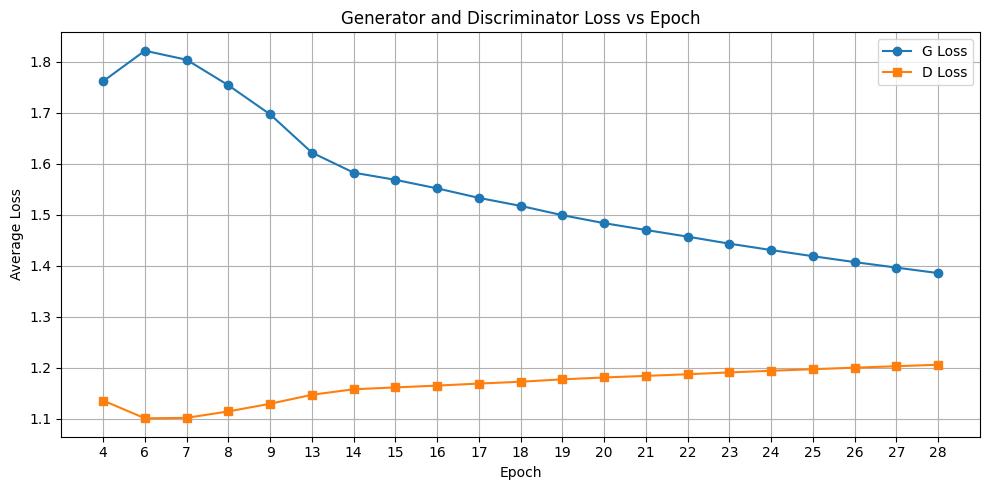

In [74]:
epoch_x = [epoch.split('/')[-1].split('_')[-1] for epoch in epochs]
# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.plot(epoch_x,G_loss, label='G Loss', marker='o')
plt.plot(epoch_x, D_loss, label='D Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Generator and Discriminator Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
# # Store all step-wise losses as dictionaries
# D_loss_all = {}
# G_loss_all = {}
# epoch_names = []

# # --- Step 1: Load per-step losses from each epoch file ---
# for epoch_path in tqdm(epochs, desc='Loading all step-wise losses'):
#     epoch_name = epoch_path.split('/')[-1]  # e.g., "epoch_01"
#     epoch_names.append(epoch_name)

#     with open(f'/kaggle/working/{epoch_name}/stargan-v2-camera_loss.txt', 'rb') as f:
#         losses = pickle.load(f)
#         D_loss_all[epoch_name] = losses['train_d2']  # store list directly
#         G_loss_all[epoch_name] = losses['train_g2']

Loading all step-wise losses:   0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
# G_loss_all['epoch_24'][:10]

In [ ]:
# for epoch in G_loss_all.keys():
#     print(f"{epoch}(min) = {min(G_loss_all[f'{epoch}'])}")
#     print(f"{epoch}(max) = {max(G_loss_all[f'{epoch}'])}")
#     print(f"{epoch}(avg) = {sum(G_loss_all[f'{epoch}'])/len(G_loss_all[f'{epoch}'])}")
#     print('\n')

In [ ]:
# # --- Step 3: Plot losses for that epoch (per step) ---
# def plot_epoch_losses(epoch_index):
#     g = G_loss_all[epoch_index]
#     d = D_loss_all[epoch_index]

#     plt.figure(figsize=(10, 5))
#     plt.plot(g, label='G Loss', marker='o')
#     plt.plot(d, label='D Loss', marker='s')
#     plt.xlabel("Step")
#     plt.ylabel("Loss")
#     plt.title(f"Loss Per Step - Epoch {epoch_names[epoch_index]}")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Example: plot losses for epoch 0
# plot_epoch_losses(epoch_index=0)

## TSME of Style Encoder

In [82]:
model.load('/kaggle/working/epoch_28/stargan-v2-camera')
model.eval()

In [83]:
style_vectors = []
labels = []

with torch.no_grad():
    for img, label in tqdm(ref_test_dataloader):
        img = img.to(device)
        label = label.to(device)

        style = model.E(img, label)  # shape: (batch, style_dim)
        style_vectors.append(style.cpu().numpy())
        labels.append(label.cpu().numpy())

  0%|          | 0/1375 [00:00<?, ?it/s]

In [84]:
style_vectors = np.concatenate(style_vectors, axis=0)
labels = np.concatenate(labels, axis=0)

In [85]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
style_tsne = tsne.fit_transform(style_vectors)

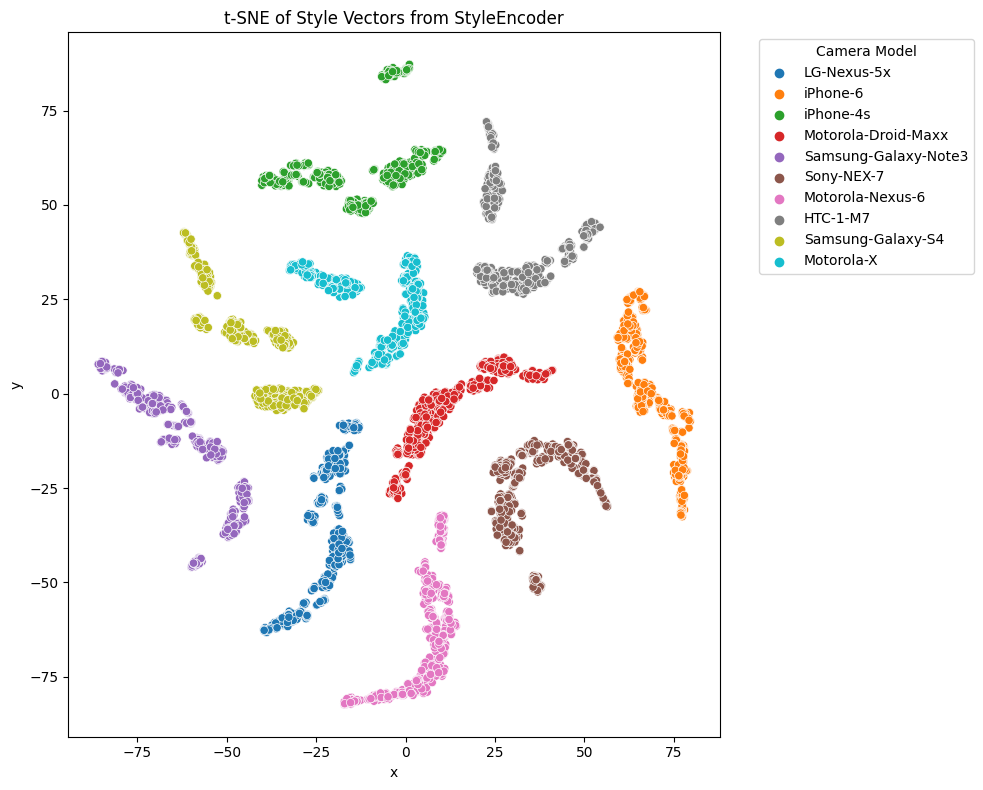

In [ ]:
import seaborn as sns
import pandas as pd

tsne_df = pd.DataFrame({
    'x': style_tsne[:, 0],
    'y': style_tsne[:, 1],
    'camera_model': le.inverse_transform(labels)
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='camera_model', palette='tab10')
plt.title('t-SNE of Style Vectors from StyleEncoder')
plt.legend(title='Camera Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Converting Full Image

In [93]:
# import cv2
# import numpy as np
# import torch

# # Pad image so it's divisible by 256
# def pad_to_multiple(img, multiple=256):
#     h, w = img.shape[:2]
#     new_h = ((h + multiple - 1) // multiple) * multiple
#     new_w = ((w + multiple - 1) // multiple) * multiple
#     pad_h = new_h - h
#     pad_w = new_w - w
#     padded_img = cv2.copyMakeBorder(img, 0, pad_h, 0, pad_w, cv2.BORDER_REFLECT)
#     return padded_img, h, w

# # Split full image into 256x256 patches
# def split_into_patches_with_coords(img, patch_size=256, stride=128):
#     patches = []
#     coords = []
#     for i in range(0, img.shape[0] - patch_size + 1, stride):
#         for j in range(0, img.shape[1] - patch_size + 1, stride):
#             patch = img[i:i+patch_size, j:j+patch_size]
#             patches.append(patch)
#             coords.append((i, j))
#     return patches, coords


# # Reconstruct full image from list of patches
# def stitch_blended(patches, coords, height, width, patch_size=256):
#     output = np.zeros((height, width, 3), dtype=np.float32)
#     weight = np.zeros((height, width, 3), dtype=np.float32)

#     for patch, (i, j) in zip(patches, coords):
#         patch = patch.astype(np.float32)
#         output[i:i+patch_size, j:j+patch_size] += patch
#         weight[i:i+patch_size, j:j+patch_size] += 1.0

#     output = (output / np.maximum(weight, 1e-5)).clip(0, 255).astype(np.uint8)
#     return output


# # Preprocess patch to tensor: [H,W,3] → [1,3,H,W]
# def preprocess_patch(patch):
#     patch = patch.astype(np.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
#     return torch.from_numpy(patch).permute(2, 0, 1).unsqueeze(0).to(device)

# # Unnormalize tensor from [-1,1] → [0,255] for display
# def unnormalize(tensor):
#     return ((tensor + 1) * 127.5).clamp(0, 255).byte()


# def stylize_full_image_blended(src_path, ref_img_tensor, ref_lbl, model, patch_size=256, stride=128):
#     img = cv2.imread(src_path)[:, :, ::-1]  # RGB
#     padded_img, orig_h, orig_w = pad_to_multiple(img, patch_size)
#     patches, coords = split_into_patches_with_coords(padded_img, patch_size, stride)

#     with torch.no_grad():
#         style = model.E(ref_img_tensor, torch.tensor([ref_lbl]).to(device))

#     stylized_patches = []

#     for patch in patches:
#         patch_tensor = preprocess_patch(patch)
#         with torch.no_grad():
#             gen_patch = model.G(patch_tensor, style)
#         gen_np = unnormalize(gen_patch[0].cpu()).permute(1, 2, 0).numpy()
#         stylized_patches.append(gen_np)

#     final_img = stitch_blended(stylized_patches, coords, padded_img.shape[0], padded_img.shape[1])
#     return final_img[:orig_h, :orig_w]



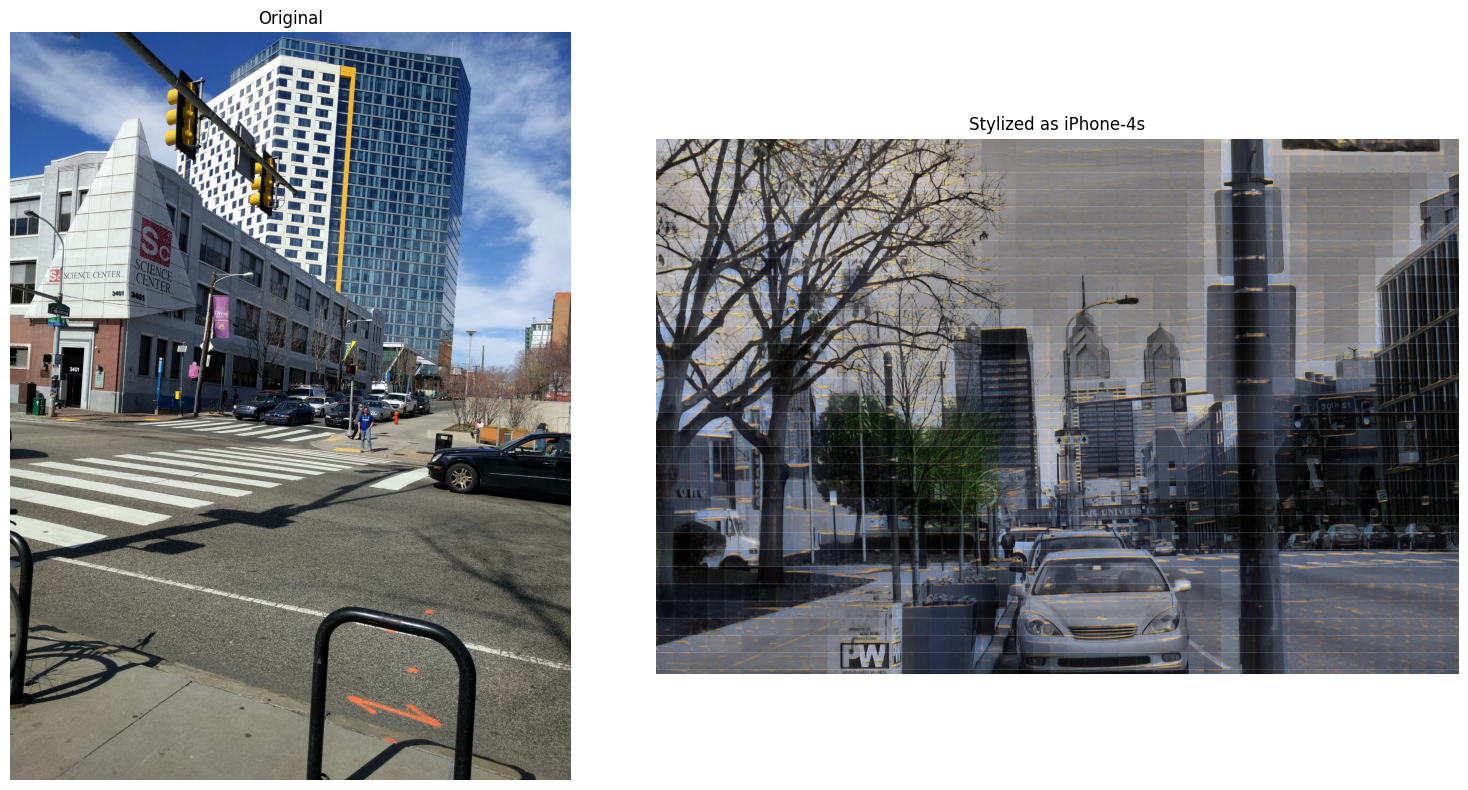

In [95]:
# import matplotlib.pyplot as plt
# import cv2

# # 1. Select reference image from your ref_df
# ref_row = ref_df.iloc[5]
# ref_img = load_image(ref_row['img_path'])     # [1,3,256,256]
# ref_lbl = ref_row['label']                    # int

# # 2. Define path to full-size source image
# src_path = '/kaggle/input/sp-society-camera-model-identification/train/train/Sony-NEX-7/(Nex7)111.JPG'

# output_img = stylize_full_image_blended(
#     src_path=src_path,
#     ref_img_tensor=ref_img,
#     ref_lbl=ref_lbl,
#     model=model
# )

# # Display
# plt.figure(figsize=(16, 8))
# plt.subplot(1, 2, 1)
# plt.imshow(orig_img)
# plt.title("Original")
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(output_img)
# plt.title(f"Stylized as {ref_row['model']}")
# plt.axis('off')
# plt.tight_layout()
# plt.show()


In [ ]:
print('')

# Utility

In [ ]:
# 1. gather files
files = glob.glob('/kaggle/working/*.pt') + glob.glob('/kaggle/working/*.pkl') + glob.glob('/kaggle/working/*.txt')

# 2. create zip
zip_path = '/kaggle/working/checkpoint_epoch_4.zip'
with zipfile.ZipFile(zip_path, 'w') as zf:
    for f in files:
        # arcname makes sure only the filename is stored, not the full path
        zf.write(f, arcname=os.path.basename(f))

print(f"✓ Created {zip_path} with {len(files)} files")

In [ ]:
base_save_dir = "/kaggle/working/saved_cameras"
zip_path = "/kaggle/working/ref_img.zip"
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=base_save_dir)

In [ ]:
# Delete file
file_path = "/kaggle/working/stargan-v2-camera_G.pt"

if os.path.exists(file_path):
    os.remove(file_path)
    print(f"✅ Deleted: {file_path}")
else:
    print("❌ File does not exist.")

In [ ]:
def delete_folder(path):
    for root, dirs, files in os.walk(path, topdown=False):
        for file in files:
            os.remove(os.path.join(root, file))
        for dir in dirs:
            os.rmdir(os.path.join(root, dir))
    os.rmdir(path)

In [ ]:
for epoch in tqdm(epochs,desc='Deleting Folders'):
    epoch_x = epoch.split('/')[-1]
    delete_folder(f'/kaggle/working/{epoch_x}')